# Toxicity Detection in Memes 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,document,notebook]"
import evadb
cursor = evadb.connect().cursor()

### Load the Memes for analysis

In [2]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme1.jpg"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme2.jpg"
response = cursor.query('DROP TABLE IF EXISTS MemeImages;').df()
cursor.query('LOAD IMAGE "meme*.jpg" INTO MemeImages;').df()

File ‘meme1.jpg’ already there; not retrieving.

File ‘meme2.jpg’ already there; not retrieving.



,0
0,Number of loaded IMAGE: 2


### Create OCR Extractor & Toxicity Classification UDF

In [3]:
cursor.query("DROP UDF OCRExtractor;").df()
cursor.create_udf("OCRExtractor", True, '../evadb/udfs/ocr_extractor_HuggingFace.py').df()

cursor.query("""DROP UDF IF EXISTS ToxicityClassifier;""").df()
cursor.create_udf("ToxicityClassifier", True, '../evadb/udfs/toxicity_classifier.py').df()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/afaanansari/Desktop/gtech/eva/test_eva_db/lib/python3.10/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,0
0,UDF ToxicityClassifier successfully added to t...


### Run Toxicity Classifier on OCR Extracted from Images

In [4]:
response = (
    cursor.query(
        """SELECT memeimages._row_id, T.label, ToxicityClassifier(label)
                  FROM MemeImages JOIN LATERAL
                  UNNEST(OCRExtractor(data)) AS T(label)
                  ;"""
    )
    .df()
)
response

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-06-15 11:21:55,069	INFO worker.py:1625 -- Started a local Ray instance.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(ray_parallel pid=61230) Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


,memeimages._row_id,T.label,toxicityclassifier.label
0,1,YOUCANTSPEL GNN,toxic
1,2,FOCK WITH鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴鋼琴...,toxic


### Visualize Model Output on Images

In [22]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_image(detections, input_image_path, image_id):

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    df = detections
    df = df.iloc[image_id]

    image = cv2.imread(input_image_path)

    if df.size:
        ocr = df['T.label']
        label = df['toxicityclassifier.label']

        plt.imshow(image)
        plt.show()

        cv2.putText(image, label, (25, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 

        cv2.putText(image, ocr, (25, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color1, thickness, cv2.LINE_AA) 

        plt.imshow(image)
        plt.show()        

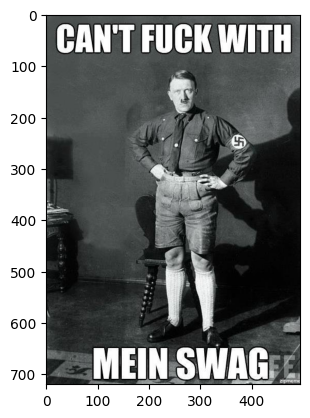

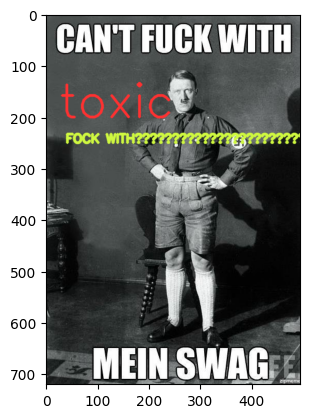

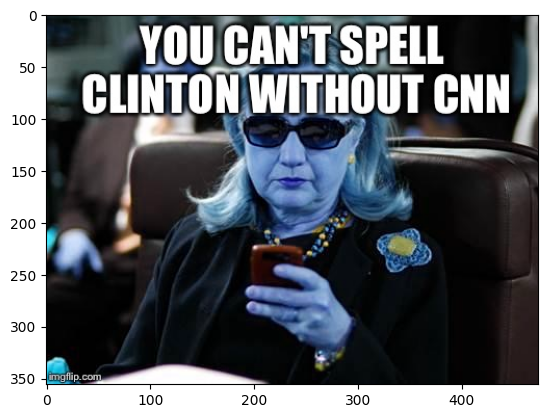

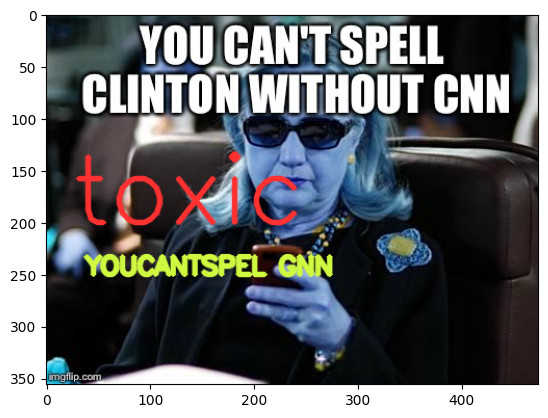

In [24]:
from ipywidgets import Image
annotate_image(response, 'meme1.jpg', image_id=1)
annotate_image(response, 'meme2.jpg', image_id=0)